In [3]:
import os
os.environ['FLYTE_PLATFORM_URL'] = "flyte-staging.lyft.net"
from flytekit.sdk.types import Types
from flytekit.common import utils
from flytekit.common.workflow_execution import SdkWorkflowExecution

from IPython.display import Image
from IPython.core.display import HTML 

In [3]:
wf = SdkWorkflowExecution.fetch(project="flytekubecondemo2019", domain="development", name="gt1785aotr")
# print(wf.outputs)

In [4]:
wf = SdkWorkflowExecution.fetch(project="flytekubecondemo2019", domain="development", name="f1487e14d159749d0a9f")
print(wf.outputs["confusion_matrix_image"])

metadata {
  type {
  }
}
uri: "s3://lyft-modelbuilder/fg/50822df4ba23a48f29afdf81aa32d326"



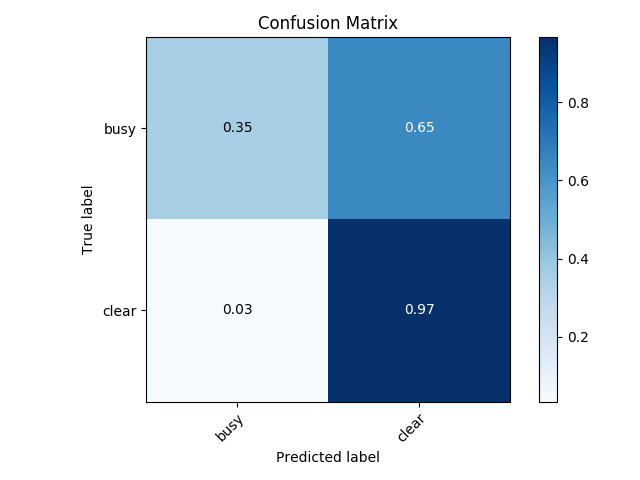

In [5]:
local_file = "/tmp/cm-4.png"
wf.outputs["confusion_matrix_image"].download(local_file, overwrite=True)
from IPython.display import Image
Image(filename=local_file)

In [6]:
from workflows.classifier_train_workflow import train_lp
from flytekit.common.launch_plan import SdkLaunchPlan

PROJECT="flytekubecondemo2019"
dataprep_wf_exec = SdkWorkflowExecution.fetch(project=PROJECT, domain="development", name="u86fgpn177-prepare-0")
frames_mpblobs = dataprep_wf_exec.outputs["selected_frames_mpblobs"]
streams_names = dataprep_wf_exec.outputs["streams_names_out"]

DEFAULT_TRAINING_VALIDATION_CONFIG_FILE = "models/classifier/resnet50/configs/model_training_config_demo.json"

train_lp = SdkLaunchPlan.fetch(
    project=PROJECT, 
    domain="development", 
    name="workflows.classifier_train_workflow.ClassifierTrainWorkflow",
    version="5bc6c1315dd310161bf59f2b926d6ab2ea92a8d8")

train_lp.execute(
    project=PROJECT,
    domain="development",
    inputs={
        "available_streams_mpblobs": frames_mpblobs,
        "available_streams_names": streams_names,
        "streams_metadata_path": "s3://lyft-modelbuilder/metadata/_FlyteKubeconDemo2019Dataset/metadata/streams_metadata.json",
    }
)

id {
  project: "flytekubecondemo2019"
  domain: "development"
  name: "f28187cc3647f41efb38"
}
spec {
  launch_plan {
    resource_type: LAUNCH_PLAN
    project: "flytekubecondemo2019"
    domain: "development"
    name: "workflows.classifier_train_workflow.ClassifierTrainWorkflow"
    version: "5bc6c1315dd310161bf59f2b926d6ab2ea92a8d8"
  }
  inputs {
    literals {
      key: "available_streams_mpblobs"
      value {
        collection {
          literals {
            scalar {
              blob {
                metadata {
                  type {
                    dimensionality: MULTIPART
                  }
                }
                uri: "s3://lyft-modelbuilder/re/0d98b28f3762b0562ed31208442008b3/"
              }
            }
          }
          literals {
            scalar {
              blob {
                metadata {
                  type {
                    dimensionality: MULTIPART
                  }
                }
                uri: "s3://lyft-m

In [4]:
PROJECT="flytekubecondemo2019"
eval_wf_exec = SdkWorkflowExecution.fetch(project=PROJECT, domain="development", name="fpn6gaba")

ground_truths_out = eval_wf_exec.get_node_executions()["evaluate-on-datasets-task"].outputs["ground_truths_out"]
predictions_out = eval_wf_exec.get_node_executions()["evaluate-on-datasets-task"].outputs["predictions_out"]



In [14]:
from utils.metric_utils.metric_utils import calculate_cutoff_youdens_j, calculate_precision_recall_curve, calculate_roc_curve
from models.classifier.resnet50.constants import DEFAULT_CLASS_LABELS, DEFAULT_POSITIVE_LABEL
from workflows.classifier_evaluate_workflow import generate_predictions

generate_predictions.unit_test(ground_truths=ground_truths_out, probabilities=predictions_out)




{'predictions': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,


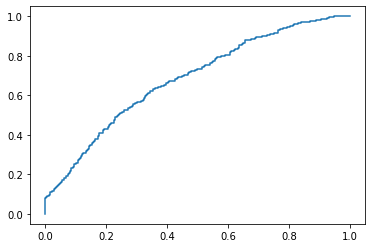

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 

In [8]:
opt, ths, preds = generate_predictions(ground_truths=ground_truths_out, probabilities=predictions_out)
print(preds)
print(opt)

In [ ]:
"""
def generate_predictions(ground_truths, probabilities):
    pos_label_idx = DEFAULT_CLASS_LABELS.index(DEFAULT_POSITIVE_LABEL)
    fpr, tpr, roc_thresholds = calculate_roc_curve(
        ground_truths,
        probabilities,
        pos_label_idx=pos_label_idx,
    )
    
    threshold_val = float(calculate_cutoff_youdens_j(tpr, fpr, roc_thresholds))
    predictions = [1 if p[pos_label_idx] > threshold_val else 0 for p in probabilities]
    thresholds = [float(v) for v in roc_thresholds]
    import matplotlib.pyplot as plt
    plt.plot(fpr, tpr)
    
    plt.show()
    return threshold_val, thresholds, predictions
#    predictions.set([1 if p[pos_label_idx] > threshold_val else 0 for p in probabilities])
#    threshold.set(threshold_val)
#    thresholds.set([float(v) for v in roc_thresholds])
"""   